In [ ]:
import os
train_dir = os.path.join('/content/drive/My Drive/SDC/IMG')
# test_dir = os.path.join('/content/drive/My Drive/dance/test')

In [ ]:
train_files = os.listdir(train_dir)
print('total training images:', len(os.listdir(train_dir)))
print(train_files[:8])

total training images: 5230
['right_2019_07_22_20_41_20_310.jpg', 'right_2019_07_22_20_41_14_637.jpg', 'right_2019_07_22_20_41_17_963.jpg', 'right_2019_07_22_20_41_18_313.jpg', 'right_2019_07_22_20_41_18_685.jpg', 'right_2019_07_22_20_41_15_806.jpg', 'right_2019_07_22_20_41_18_453.jpg', 'right_2019_07_22_20_41_20_624.jpg']


In [ ]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

Lets retrieve the dataset from drive

In [ ]:
# get file names of frames
col_frames = os.listdir('/content/drive/My Drive/SDC/IMG')
# col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))
col_frames.sort()
# print(col_frames)
# load frames
col_images=[]
for i in col_frames[500:1000]:
    img = cv2.imread('/content/drive/My Drive/SDC/IMG/'+i)
    col_images.append(img)

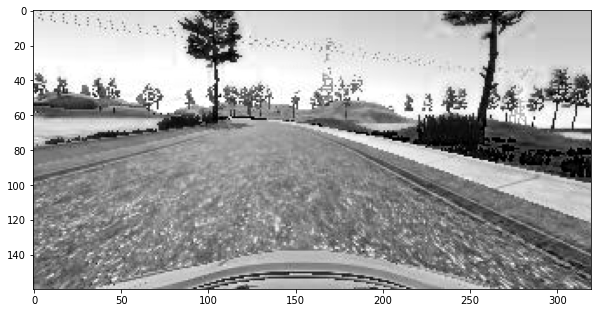

In [ ]:
# specify frame index
idx = 0

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx][:,:,0], cmap= "gray")
plt.show()

In [ ]:
# create a zero array
stencil = np.zeros_like(col_images[idx][:,:,0])

# prepare a mask for height and width pixel values where road is only visible not sky, hills, etc.
# specify coordinates of the polygon
polygon = np.array([[0,140], [0,65], [320,65], [320,140]])
# polygon = np.array([[60,0], [40,100], [40,200], [60,320]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Lets see how our mask looks

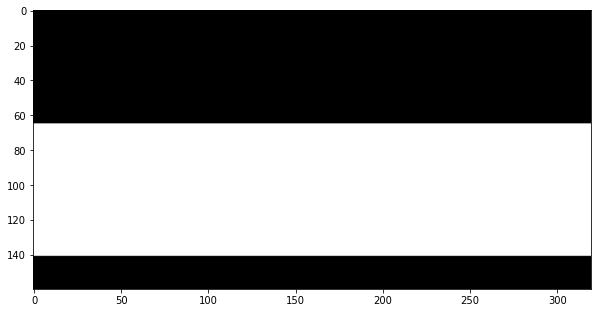

In [ ]:
# plot polygon
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

Lets apply this mask to images

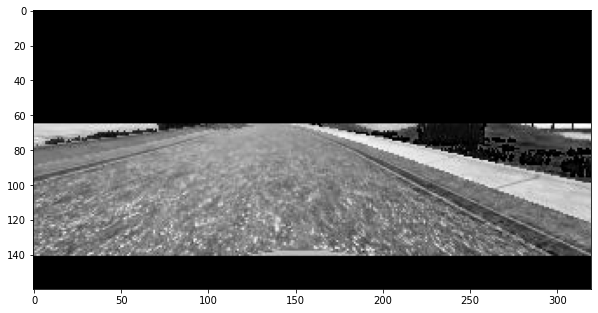

In [ ]:
# apply polygon as a mask on the frame
img = cv2.bitwise_and(col_images[idx][:,:,0], col_images[idx][:,:,0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

In [ ]:
# mask = cv2.inRange(img,210,250)
# thresh = cv2.bitwise_and(img,img,mask = mask)

In [ ]:
# thresh = cv2.Laplacian(img, cv2.CV_64F)
# # thresh = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
# # thresh = cv2.Sobel(lap,cv2.CV_8U,0,1,ksize=5)

Lets see the effect after applying thresholds to detect the lanes

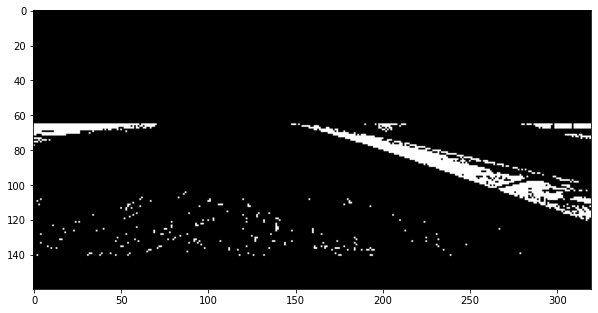

In [ ]:
# apply image thresholding
ret, thresh = cv2.threshold(img,200,250, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

Now apply hough line transform over the thresholded image, it will find the straight lines in the picture.

19


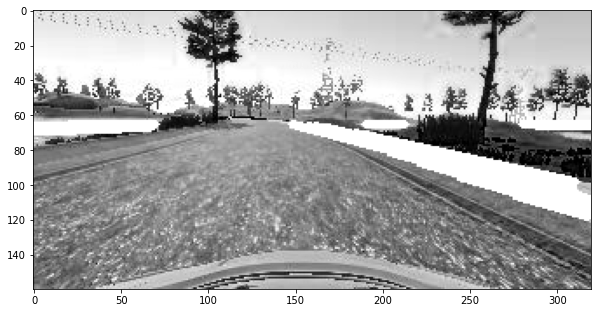

In [ ]:

lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 35, maxLineGap=30)
print(len(lines))
# create a copy of the original frame
dmy = col_images[idx][:,:,0].copy()

# draw Hough lines
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()

Seperate these lines into left lane and right lane

In [ ]:
left=[]
right=[]
for i in range(len(lines)):
  if lines[i][0][1]<lines[i][0][3]:
     lines[i][0][0],lines[i][0][1],lines[i][0][2],lines[i][0][3]=lines[i][0][2],lines[i][0][3],lines[i][0][0],lines[i][0][1]
  l=lines[i]
  if l[0][0]>150 or l[0][2]>150:
    right.append(l[0])
  else:
    left.append(l[0])

In [ ]:
print(left)
print(right)

[array([ 0, 66, 69, 66], dtype=int32), array([ 0, 67, 67, 67], dtype=int32), array([ 0, 69, 50, 68], dtype=int32), array([20, 65, 70, 65], dtype=int32)]
[array([319, 109, 157,  66], dtype=int32), array([318, 110, 148,  65], dtype=int32), array([305, 103, 168,  67], dtype=int32), array([280,  65, 319,  65], dtype=int32), array([319, 112, 204,  81], dtype=int32), array([319, 115, 221,  87], dtype=int32), array([158,  67, 160,  67], dtype=int32), array([311,  98, 190,  71], dtype=int32), array([310, 103, 184,  70], dtype=int32), array([319, 117, 244,  95], dtype=int32), array([318, 114, 239,  92], dtype=int32), array([288,  66, 319,  66], dtype=int32), array([190,  65, 213,  65], dtype=int32), array([319, 108, 161,  66], dtype=int32), array([318, 118, 276, 106], dtype=int32)]


In [ ]:
left=np.array(left)
right=np.array(right)

There could be multi lines in left lanes and right lane after hough transformation thus we need to find a single left and right lane vector

In [ ]:
if len(left):
  left=np.mean(left,axis=0)
if len(right)>0:
  right=np.mean(right,axis=0)

In [ ]:
print(left) # left lane vector
print(right) # right lane vector

[ 5.   66.75 64.   66.5 ]
[292.73333333  98.         213.53333333  75.26666667]


Lets see how these vectors look in images

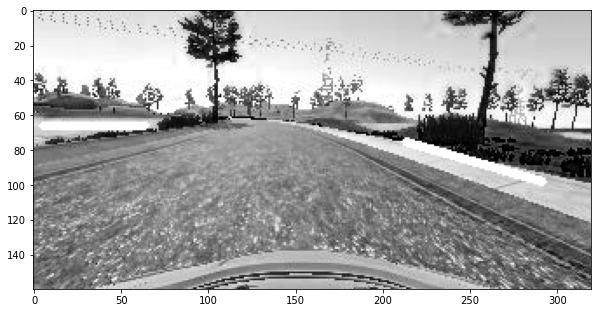

In [ ]:
dmy = col_images[idx][:,:,0].copy()
x1, y1, x2, y2 = left if len(left)>0 else [0,0,0,0]
if len(left)>0:
  cv2.line(dmy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
x1, y1, x2, y2 = right if len(right)>0 else [0,0,0,0]
if len(right)>0:
  cv2.line(dmy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()

Now based on these vectors we will predict the steering angle. And then using a arrow we will visualize this steering angle, that in which direction and how much we need to take a turn.

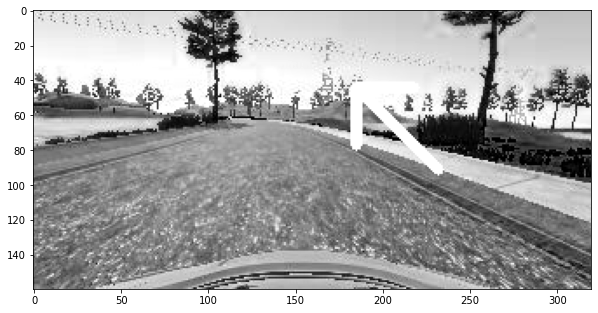

In [ ]:
import math
arr=[]
for l in lines:
  arr.append(l[0])
arr=np.array(arr)
arrow=arr.mean(axis=0)
mag=math.sqrt((arrow[0]-arrow[2])**2 + (arrow[1]-arrow[3])**2)
start_point=np.array([arrow[0],arrow[1]])
vector =np.array(arrow[0]-arrow[2],arrow[1]-arrow[3])
end_point=start_point-50*(vector/mag)
start_point=(int(start_point[0]),int(start_point[1]))
end_point=(int(end_point[0]),int(end_point[1]))
# Line thickness of 9 px  
thickness = 5
image = cv2.arrowedLine(col_images[idx][:,:,0].copy(), start_point, end_point,(255,0,0),thickness, tipLength = 0.5)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap= "gray")
plt.show()

Now do the same for all images and keep on storing them in a video frame by frame.

In [ ]:
import math
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/drive/My Drive/SDC/output_opencv.mp4',fourcc, 15, (320,160))
cnt = 0
for img in col_images:
  # apply frame mask
  masked = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)
  # apply image thresholding
  ret, thresh = cv2.threshold(masked, 190, 250, cv2.THRESH_BINARY)
  lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 35, maxLineGap=25)
  left=[]
  right=[]
  if lines is None:
    lines=np.array([[[150,160,150,100]]])
  for i in range(len(lines)):
    if lines[i][0][1]<lines[i][0][3]:
      lines[i][0][0],lines[i][0][1],lines[i][0][2],lines[i][0][3]=lines[i][0][2],lines[i][0][3],lines[i][0][0],lines[i][0][1]
    l=lines[i]
    if l[0][0]>150 or l[0][2]>150:
      right.append(l[0])
    else:
      left.append(l[0])
  left=np.array(left)
  right=np.array(right)
  if len(left):
    left=np.mean(left,axis=0)
  if len(right)>0:
    right=np.mean(right,axis=0)
  dmy = img[:,:,0].copy()
  if len(left)>0:
    x1, y1, x2, y2 = left
  else:
    x1,y1,x2,y2=0,0,0,0
  if len(left)>0:
    cv2.line(dmy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
  if len(right)>0:
    x1, y1, x2, y2 = right
  else: 
    x1,y1,x2,y2=0,0,0,0
  if len(right)>0:
    cv2.line(dmy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
  # plot frame
  arr=[]
  ans=np.array([0,0,0,0])
  for l in lines:
    arrow=l[0]
    mag=math.sqrt((arrow[0]-arrow[2])**2 + (arrow[1]-arrow[3])**2)
    ans=ans+mag*arrow
  mag=math.sqrt((ans[0]-ans[2])**2 + (ans[1]-ans[3])**2)
  ans=ans/mag * 40
  ans=ans-np.array([ans[0],ans[1],ans[0],ans[1]])+np.array([150,80,150,80])
  # arr=np.array(arr)
  # arrow=arr.mean(axis=0)
  # mag=math.sqrt((arrow[0]-arrow[2])**2 + (arrow[1]-arrow[3])**2)
  # start_point=np.array([arrow[0],arrow[1]])
  # vector =np.array(arrow[0]-arrow[2],arrow[1]-arrow[3])
  # end_point=start_point-50*(vector/mag)
  start_point=(int(ans[0]),int(ans[1]))
  end_point=(int(ans[2]),int(ans[3]))
  # Line thickness of 9 px  
  thickness = 5
  image = cv2.arrowedLine(dmy, start_point, end_point,(255,0,0),thickness, tipLength = 0.5)
  plt.figure(figsize=(10,10))
  plt.imshow(image, cmap= "gray")
  plt.show()

  # # apply Hough Line Transformation
  # lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 35, maxLineGap=30)
  # dmy = img.copy()
  
  # # Plot detected lines
  # try:
  #   for line in lines:
  #     x1, y1, x2, y2 = line[0]
  #     cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
  
  # cv2.imwrite('/content/drive/My Drive/SDC/detected/'+str(cnt)+'.png',image)
  out.write(image)
  
  # except TypeError: 
  #   cv2.imwrite('detected/'+str(cnt)+'.png',img)

  cnt+= 1

out.release()
cv2.destroyAllWindows()